In [9]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# ===============================
# 1. Fetch OHLCV data (Binance, 1h)
# ===============================
exchange = ccxt.binance()
bars = exchange.fetch_ohlcv('BTC/USDT', timeframe='1h', limit=2000)

df = pd.DataFrame(bars, columns=["Time","Open","High","Low","Close","Volume"])
df["Time"] = pd.to_datetime(df["Time"], unit="ms")
df.set_index("Time", inplace=True)

In [11]:
import talib
df["DEMA9"] = talib.DEMA(df["Close"].values, timeperiod=9)

In [12]:
# -------------------------
# 3) Swing detection (5 candles before & after)
# -------------------------
lookback = 5   # 5 candles before and after as you requested

def detect_swings(prices, highs, lows, lookback=5):
    labels = np.zeros(len(prices), dtype=int)
    for i in range(lookback, len(prices) - lookback):
        # Swing High
        if highs[i] == max(highs[i-lookback:i+lookback+1]):
            labels[i] = -1  # Downtrend reversal (swing high)
        # Swing Low
        elif lows[i] == min(lows[i-lookback:i+lookback+1]):
            labels[i] = 1   # Uptrend reversal (swing low)
        else:
            labels[i] = 0
    return labels

df = df.dropna(subset=["Close"])  # just in case
df["Label"] = detect_swings(df["Close"].values, df["High"].values, df["Low"].values, lookback=lookback)

# drop rows missing DEMA (beginning of series)
df.dropna(subset=["DEMA9"], inplace=True)


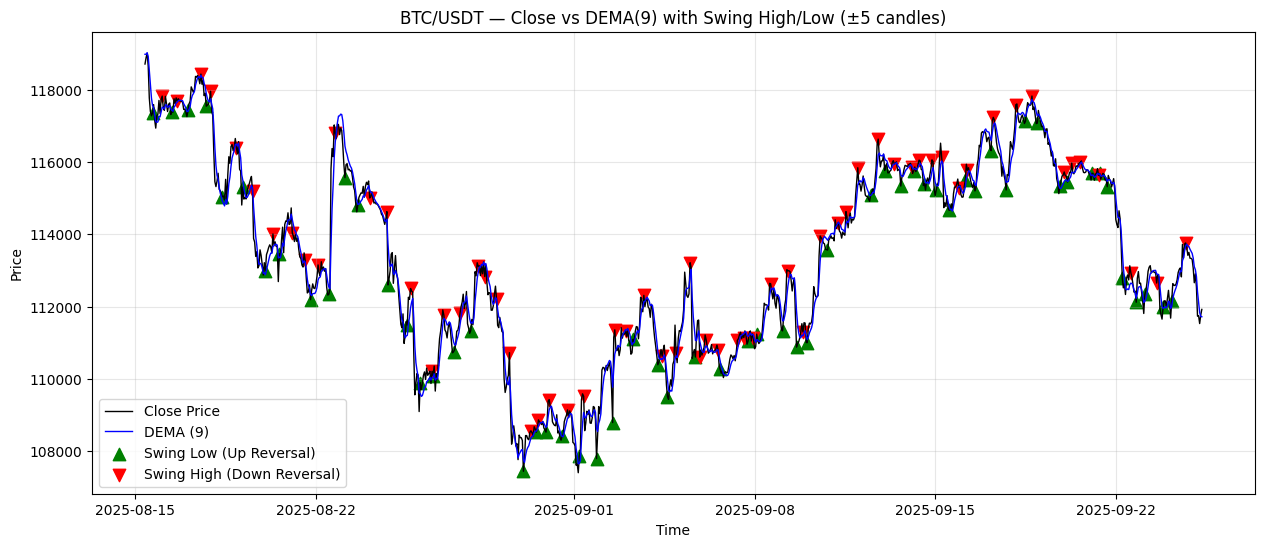

In [14]:
# -------------------------
# 4) Plot Price vs DEMA9 + Swing markers
# -------------------------
symbol = "BTC/USDT"
plt.figure(figsize=(15,6))
plt.plot(df.index, df["Close"], label="Close Price", color="black", linewidth=1)
plt.plot(df.index, df["DEMA9"], label="DEMA (9)", color="blue", linewidth=1)

# Swing lows (up reversals)
plt.scatter(df.index[df["Label"]==1], df["Close"][df["Label"]==1], marker="^", color="green", s=80, label="Swing Low (Up Reversal)")

# Swing highs (down reversals)
plt.scatter(df.index[df["Label"]==-1], df["Close"][df["Label"]==-1], marker="v", color="red", s=80, label="Swing High (Down Reversal)")

plt.title(f"{symbol} — Close vs DEMA(9) with Swing High/Low (±{lookback} candles)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


<Figure size 800x600 with 0 Axes>

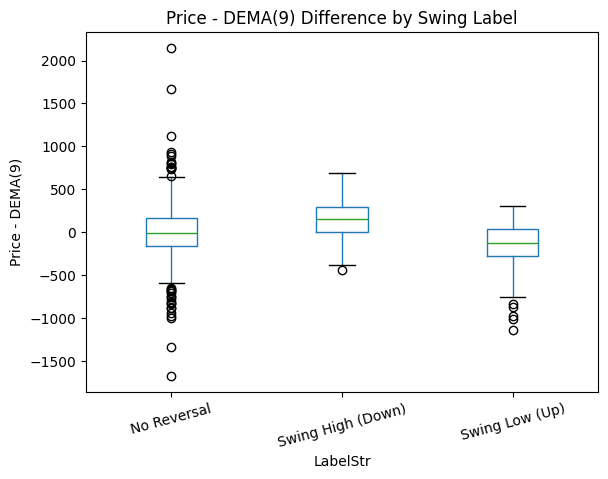

Saved btc_dema9_swing_labels.csv — rows: 984


In [15]:
# -------------------------
# 5) Boxplot: Price - DEMA at labels
# -------------------------
df["Diff"] = df["Close"] - df["DEMA9"]
box_df = df[["Diff","Label"]].copy()
box_df["LabelStr"] = box_df["Label"].map({-1: "Swing High (Down)", 1: "Swing Low (Up)", 0: "No Reversal"})

plt.figure(figsize=(8,6))
box_df.boxplot(column="Diff", by="LabelStr", grid=False)
plt.title("Price - DEMA(9) Difference by Swing Label")
plt.suptitle("")
plt.ylabel("Price - DEMA(9)")
plt.xticks(rotation=15)
plt.show()

# -------------------------
# 6) Optional: Save CSV
# -------------------------
out_cols = ["Open","High","Low","Close","Volume","DEMA9","Label","Diff"]
df[out_cols].to_csv("btc_dema9_swing_labels.csv")
print("Saved btc_dema9_swing_labels.csv — rows:", len(df))